In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import sksurv

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [2]:
from data.utils import SimpleDataset
# from torch.utils.data import Dataset, DataLoader, Sampler
# class SimpleDataset(Dataset):
#     def __init__(self, x, y, e, transform=False, covlist = None, mean=0, std = 1):
#         self.data = x
#         self.targets = y
#         self.label = e
#         self.transform = transform
#         self.covlist = covlist
#         if not self.covlist:
#             self.covlist = np.arange(self.data.shape[1])
        
#         if self.transform:
#             self.mean, self.std = mean, std
            
#     def __getitem__(self, index):
#         img = self.data[index]
#         target = self.targets[index]
#         label = self.label[index]
        
#         if self.transform:
#             return (img[self.covlist]-self.mean)/self.std, target, label
#         else:
#             return img, target, label
        
        

#     def __len__(self):
#         return len(self.data)
  

## Cox-gompertz linear setting

Load framingham dataset

In [3]:
from data.simulation import simulation_cox_weibull_all, single_subj_true_dist_cox_gompertz

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy_bin/e40'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

df= simulation_cox_weibull_all(n=20000, censor_bound=68)

# change to non-ohe 

nsamples, ncov= df['x'].shape
cat0 = np.arange(df['ohe'][0])
cat1 = np.arange(df['ohe'][1])
cov_list = np.array(['AGE','RANDON']+['cat0_'+str(a) for a in cat0]+['cat1_'+str(a) for a in cat1])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]

true_beta = df['coef']
ncov, np.mean(df['e'])

(57, 0.41815)

In [4]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

del df

observed fold:0.4176854421360534
observed fold:0.41907904604769763


### Discretized the timeline

In [5]:
# # helper functions
# # transform t into categories
# # one-hot-encoding
# # only consider the nearest category to the left
# ##### for re-formulate time #####
# def t_tt_idx(t_,tt):
#     t_diff = t_-tt
#     t_diff_sign = (t_diff>=0)
#     if len(t_diff[t_diff_sign])>0:
#         idx = torch.argmin(t_diff[t_diff_sign])
#     else:
#         idx = 0
#     return idx


# def t_label(t_,tt):
#     nbin = len(tt)
#     t_diff = t_-tt
#     t_diff_sign = (t_diff>=0)
#     if len(t_diff[t_diff_sign])>0:
#         idx = torch.argmin(t_diff[t_diff_sign])
#         t_cat = torch.zeros(nbin).to(t_.device)
#         t_cat[idx] = 1.0
#     else:
#         t_cat = torch.zeros(nbin).to(t_.device)
#         t_cat[0] = 1.0
#     return t_cat

# def t_label_censor(t_, tt):
#     t_idx = t_tt_idx(t_,tt)
#     t_prob = torch.cat([torch.zeros(t_idx), torch.ones(len(tt)-t_idx)])
#     return t_prob.to(t_.device)


# def t_categorize(t_, e_, tt):
#     if e_ == 1:
#         t_cat = t_label(t_,tt)
#     else:
#         t_cat = t_label_censor(t_, tt)
#     return t_cat
    
# def batch_t_categorize(batch_t, batch_e, tt):
#     nbin = len(tt)
#     nbatch = batch_t.shape[0]
#     all_cat = [t_categorize(batch_t[obs], batch_e[obs], tt) for obs in np.arange(nbatch)]  
#     return torch.vstack(all_cat)


In [6]:
# batch_t_categorize(torch.tensor([15,30,90]).to(device), torch.tensor([1,0,1]).to(device), tt)

In [7]:
t_bin=100
# tt = np.percentile(train['t'][train['e']==1],np.linspace(0.,100.,nbin, endpoint=True))
tt = np.linspace(0.,np.max(train['t'][train['e']==1]),t_bin, endpoint=True)

# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    t_bin = t_bin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)
t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
tt, t_all_max, t_max

(array([ 0.        ,  0.68266596,  1.36533193,  2.04799789,  2.73066385,
         3.41332981,  4.09599578,  4.77866174,  5.4613277 ,  6.14399367,
         6.82665963,  7.50932559,  8.19199155,  8.87465752,  9.55732348,
        10.23998944, 10.9226554 , 11.60532137, 12.28798733, 12.97065329,
        13.65331926, 14.33598522, 15.01865118, 15.70131714, 16.38398311,
        17.06664907, 17.74931503, 18.431981  , 19.11464696, 19.79731292,
        20.47997888, 21.16264485, 21.84531081, 22.52797677, 23.21064273,
        23.8933087 , 24.57597466, 25.25864062, 25.94130659, 26.62397255,
        27.30663851, 27.98930447, 28.67197044, 29.3546364 , 30.03730236,
        30.71996833, 31.40263429, 32.08530025, 32.76796621, 33.45063218,
        34.13329814, 34.8159641 , 35.49863007, 36.18129603, 36.86396199,
        37.54662795, 38.22929392, 38.91195988, 39.59462584, 40.2772918 ,
        40.95995777, 41.64262373, 42.32528969, 43.00795566, 43.69062162,
        44.37328758, 45.05595354, 45.73861951, 46.4

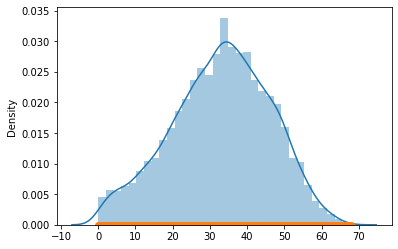

In [8]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')

<AxesSubplot:ylabel='Density'>

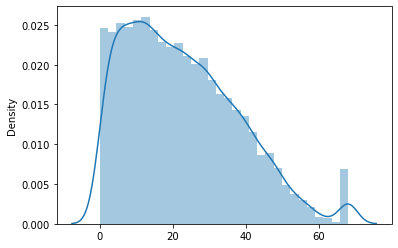

In [9]:
sns.distplot(train['t'][train['e']==0])

In [10]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP_cts(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP_cts, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return z

    
class DecMLP_bin(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(DecMLP_bin, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [11]:
ncov = train['x'].shape[1]
# covList = np.arange(ncov)
train_mean = np.zeros(ncov)
train_std = np.ones(ncov)

for idx in cts_idx:
    train_mean[idx] = np.mean(train['x'][:,idx])
    train_std[idx] = np.std(train['x'][:,idx])

trainData = SimpleDataset(train['x'], train['t'], train['e'], transform=True, mean=train_mean, std = train_std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'], transform=True, mean=train_mean, std = train_std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

# train_mean, train_std
train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

In [12]:
result_path_root

'/data/zidi/ACSurv/results/toy_bin/e40'

In [13]:
from utils.metrics import NLL_reg, point_loss, get_CI_raw
from utils.trainer_helpers import batch_t_categorize, wt_avg

# def NLL_reg(p_raw, y, e, tt):
#     # using likelihood to regularize the performance
#     y_cat = batch_t_categorize(y, e, tt)
#     #         keep_idx = torch.where(y <= t_max)[0]

#     y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-6).log().sum()
#     #  -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
    
#     return y_loglikeli

# def calculate_quantiles(post_prob, tt, percentiles):
#     post_prob_sums = torch.cumsum(post_prob,axis=1)
#     try:
#         tt_p = [tt[torch.argmin(torch.abs(post_prob_sum-p))] for p in percentiles]
#     except TypeError:
#         tt_p = tt[torch.argmin(torch.abs(post_prob_sum-percentiles))]
#         tt_p = [tt_p]
        
#     return tt_p

# def get_median(p_raw, tt, percentile):
#     post_prob_sums = torch.cumsum(p_raw,axis=1)
#     tt_idx = torch.argmin(torch.abs(post_prob_sums-percentile),axis=1)
#     t_med_hat = tt[tt_idx]
#     return t_med_hat

# def wt_avg(p_raw, tt):
#     # calculate the averaged sum of these bins as a summary
#     t_wa_hat = (p_raw*tt).sum(1)
#     return t_wa_hat
    

In [14]:
# def point_loss(t_hat, y, loss_type='MSE'):
#     # point estimation loss based on the predicted raw probabilities
#     hinge_loss,_ = torch.min(torch.cat([t_hat.unsqueeze(1)-y.unsqueeze(1), torch.zeros_like(t_hat.unsqueeze(1)).to(y.device)], dim=1), 1, keepdim=True)
    
    
#     if loss_type == 'MSE':
#         eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
#         closs = ((1-e)*torch.pow(hinge_loss.squeeze(),2)).sum()
#     elif loss_type == 'MAE':
#         eloss = (e*torch.abs(y-t_hat.squeeze())).sum()
#         closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
#     elif loss_type == 'RAE':
#         eloss = (e*torch.abs(y-t_hat.squeeze())/t_hat.squeeze()).sum()
#         closs = ((1-e)*torch.abs(hinge_loss.squeeze())/t_hat.squeeze()).sum()
        
#     return eloss, closs

In [15]:
# from sksurv.metrics import concordance_index_censored
# def get_CI_raw(event, true_t, pred_t):
#     return concordance_index_censored((event.squeeze().cpu().detach().numpy()).astype(bool), true_t.squeeze().cpu().detach().numpy(), -pred_t.squeeze().cpu().detach().numpy())


In [16]:
zdim = 10
epochs = 1000
device = 'cuda'
model_name = 'MLP'

# point estimation loss function and weight
loss_type='MSE'
lambda_ = 0



result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

# bined time
tt = torch.tensor(tt).to(device)

# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128, 128])
decoder = DecMLP_bin(input_size = zdim, output_size = t_bin, h_dim=[128, 128])

encoder.to(device)
decoder.to(device)

# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
enc_path = result_path+model_name+'_enc.pt'
dec_path = result_path+model_name+'_dec.pt'

print(encoder, decoder)
print(enc_path, dec_path)

EncMLP(
  (net): Sequential(
    (0): Linear(in_features=57, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
) DecMLP_bin(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=101, bias=True)
  )
  (out): Softmax(dim=1)
)
/data/zidi/ACSurv/results/toy_bin/e40/saved_models/MLP_enc.pt /data/zidi/ACSurv/results/toy_bin/e40/saved_models/MLP_dec.pt


epoch1
improved
====> Train NLL: 2.219 	 Valid NLL: 2.239 CI: 0.702 event loss: 72.912 	 censoring loss : 29.707 	 Improved: *
epoch2
improved
====> Train NLL: 2.213 	 Valid NLL: 2.233 CI: 0.786 event loss: 73.125 	 censoring loss : 29.033 	 Improved: *
epoch3
improved
====> Train NLL: 2.206 	 Valid NLL: 2.224 CI: 0.797 event loss: 73.437 	 censoring loss : 28.138 	 Improved: *
epoch4
====> Train NLL: 2.195 	 Valid NLL: 2.211 CI: 0.787 event loss: 73.952 	 censoring loss : 26.828 	 Improved:  
epoch5
====> Train NLL: 2.179 	 Valid NLL: 2.190 CI: 0.788 event loss: 74.857 	 censoring loss : 24.703 	 Improved:  
epoch6
improved
====> Train NLL: 2.153 	 Valid NLL: 2.157 CI: 0.802 event loss: 76.581 	 censoring loss : 21.186 	 Improved: *
epoch7
improved
====> Train NLL: 2.112 	 Valid NLL: 2.108 CI: 0.823 event loss: 80.047 	 censoring loss : 16.306 	 Improved: *
epoch8
improved
====> Train NLL: 2.061 	 Valid NLL: 2.053 CI: 0.846 event loss: 83.728 	 censoring loss : 11.292 	 Improved: *
ep

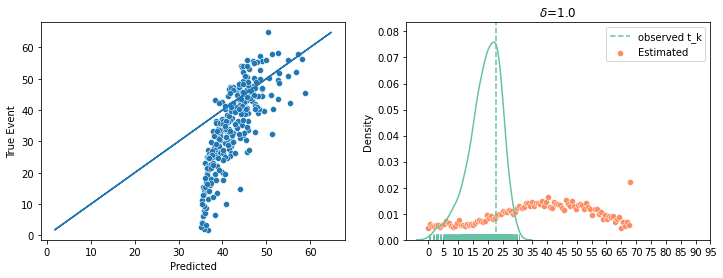

improved
====> Train NLL: 1.966 	 Valid NLL: 1.960 CI: 0.875 event loss: 76.561 	 censoring loss : 1.885 	 Improved: *
epoch11
improved
====> Train NLL: 1.937 	 Valid NLL: 1.937 CI: 0.885 event loss: 71.977 	 censoring loss : 1.568 	 Improved: *
epoch12
improved
====> Train NLL: 1.917 	 Valid NLL: 1.919 CI: 0.890 event loss: 70.527 	 censoring loss : 1.382 	 Improved: *
epoch13
improved
====> Train NLL: 1.900 	 Valid NLL: 1.905 CI: 0.893 event loss: 65.838 	 censoring loss : 1.594 	 Improved: *
epoch14
improved
====> Train NLL: 1.885 	 Valid NLL: 1.890 CI: 0.895 event loss: 60.391 	 censoring loss : 1.607 	 Improved: *
epoch15
improved
====> Train NLL: 1.868 	 Valid NLL: 1.870 CI: 0.895 event loss: 53.492 	 censoring loss : 1.512 	 Improved: *
epoch16
improved
====> Train NLL: 1.843 	 Valid NLL: 1.841 CI: 0.896 event loss: 43.325 	 censoring loss : 1.313 	 Improved: *
epoch17
improved
====> Train NLL: 1.810 	 Valid NLL: 1.806 CI: 0.896 event loss: 32.737 	 censoring loss : 1.333 	 Impr

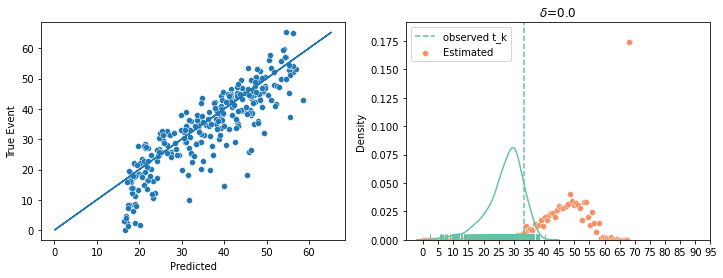

improved
====> Train NLL: 1.716 	 Valid NLL: 1.724 CI: 0.896 event loss: 23.129 	 censoring loss : 1.176 	 Improved: *
epoch21
improved
====> Train NLL: 1.695 	 Valid NLL: 1.707 CI: 0.896 event loss: 21.795 	 censoring loss : 1.303 	 Improved: *
epoch22
improved
====> Train NLL: 1.678 	 Valid NLL: 1.693 CI: 0.896 event loss: 21.274 	 censoring loss : 1.256 	 Improved: *
epoch23
improved
====> Train NLL: 1.664 	 Valid NLL: 1.683 CI: 0.897 event loss: 20.577 	 censoring loss : 1.353 	 Improved: *
epoch24
improved
====> Train NLL: 1.653 	 Valid NLL: 1.674 CI: 0.897 event loss: 20.698 	 censoring loss : 1.102 	 Improved: *
epoch25
improved
====> Train NLL: 1.644 	 Valid NLL: 1.665 CI: 0.897 event loss: 20.033 	 censoring loss : 1.201 	 Improved: *
epoch26
improved
====> Train NLL: 1.636 	 Valid NLL: 1.659 CI: 0.898 event loss: 19.877 	 censoring loss : 1.152 	 Improved: *
epoch27
improved
====> Train NLL: 1.629 	 Valid NLL: 1.654 CI: 0.898 event loss: 19.982 	 censoring loss : 1.040 	 Impr

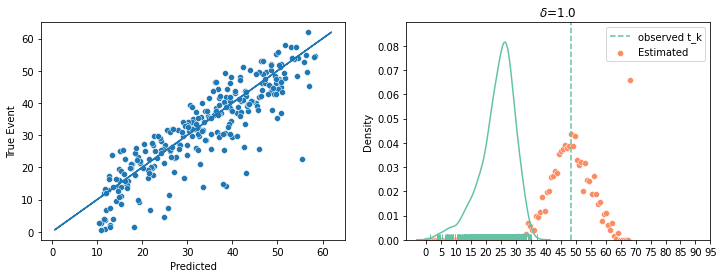

improved
====> Train NLL: 1.613 	 Valid NLL: 1.640 CI: 0.898 event loss: 19.465 	 censoring loss : 1.014 	 Improved: *
epoch31
improved
====> Train NLL: 1.609 	 Valid NLL: 1.638 CI: 0.898 event loss: 18.977 	 censoring loss : 1.029 	 Improved: *
epoch32
improved
====> Train NLL: 1.605 	 Valid NLL: 1.634 CI: 0.898 event loss: 19.060 	 censoring loss : 1.011 	 Improved: *
epoch33
improved
====> Train NLL: 1.602 	 Valid NLL: 1.631 CI: 0.898 event loss: 19.006 	 censoring loss : 0.917 	 Improved: *
epoch34
improved
====> Train NLL: 1.599 	 Valid NLL: 1.630 CI: 0.899 event loss: 18.908 	 censoring loss : 0.937 	 Improved: *
epoch35
improved
====> Train NLL: 1.596 	 Valid NLL: 1.627 CI: 0.899 event loss: 18.805 	 censoring loss : 0.940 	 Improved: *
epoch36
improved
====> Train NLL: 1.594 	 Valid NLL: 1.626 CI: 0.899 event loss: 18.578 	 censoring loss : 0.983 	 Improved: *
epoch37
improved
====> Train NLL: 1.591 	 Valid NLL: 1.624 CI: 0.899 event loss: 18.684 	 censoring loss : 0.884 	 Impr

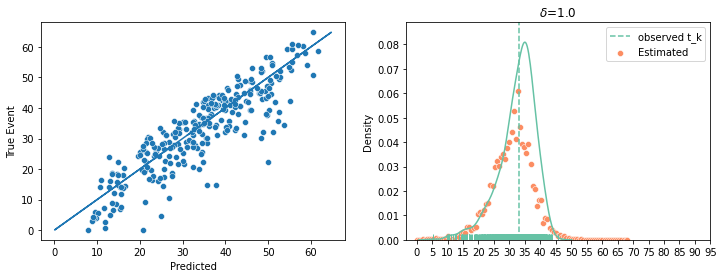

improved
====> Train NLL: 1.586 	 Valid NLL: 1.620 CI: 0.899 event loss: 18.849 	 censoring loss : 0.767 	 Improved: *
epoch41
improved
====> Train NLL: 1.585 	 Valid NLL: 1.618 CI: 0.899 event loss: 18.341 	 censoring loss : 0.856 	 Improved: *
epoch42
improved
====> Train NLL: 1.583 	 Valid NLL: 1.618 CI: 0.899 event loss: 18.204 	 censoring loss : 0.904 	 Improved: *
epoch43
improved
====> Train NLL: 1.581 	 Valid NLL: 1.616 CI: 0.899 event loss: 18.290 	 censoring loss : 0.846 	 Improved: *
epoch44
====> Train NLL: 1.580 	 Valid NLL: 1.616 CI: 0.899 event loss: 18.509 	 censoring loss : 0.759 	 Improved:  
epoch45
improved
====> Train NLL: 1.578 	 Valid NLL: 1.615 CI: 0.899 event loss: 18.031 	 censoring loss : 0.905 	 Improved: *
epoch46
====> Train NLL: 1.577 	 Valid NLL: 1.614 CI: 0.899 event loss: 18.227 	 censoring loss : 0.812 	 Improved:  
epoch47
improved
====> Train NLL: 1.576 	 Valid NLL: 1.613 CI: 0.899 event loss: 18.495 	 censoring loss : 0.710 	 Improved: *
epoch48
im

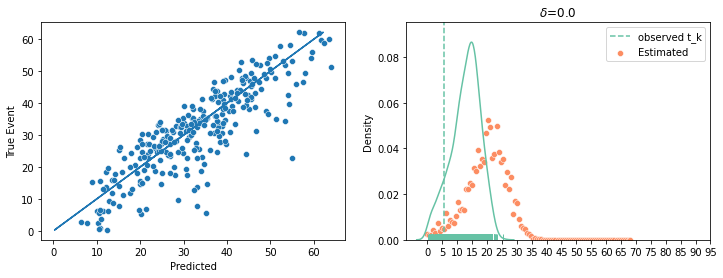

improved
====> Train NLL: 1.573 	 Valid NLL: 1.611 CI: 0.899 event loss: 18.270 	 censoring loss : 0.749 	 Improved: *
epoch51
improved
====> Train NLL: 1.571 	 Valid NLL: 1.610 CI: 0.899 event loss: 17.975 	 censoring loss : 0.832 	 Improved: *
epoch52
====> Train NLL: 1.571 	 Valid NLL: 1.610 CI: 0.899 event loss: 18.227 	 censoring loss : 0.760 	 Improved:  
epoch53
improved
====> Train NLL: 1.571 	 Valid NLL: 1.609 CI: 0.899 event loss: 18.131 	 censoring loss : 0.759 	 Improved: *
epoch54
improved
====> Train NLL: 1.569 	 Valid NLL: 1.609 CI: 0.899 event loss: 17.893 	 censoring loss : 0.823 	 Improved: *
epoch55
improved
====> Train NLL: 1.569 	 Valid NLL: 1.608 CI: 0.899 event loss: 17.933 	 censoring loss : 0.814 	 Improved: *
epoch56
====> Train NLL: 1.567 	 Valid NLL: 1.609 CI: 0.899 event loss: 18.354 	 censoring loss : 0.647 	 Improved:  
epoch57
====> Train NLL: 1.567 	 Valid NLL: 1.607 CI: 0.899 event loss: 18.183 	 censoring loss : 0.700 	 Improved:  
epoch58
improved
==

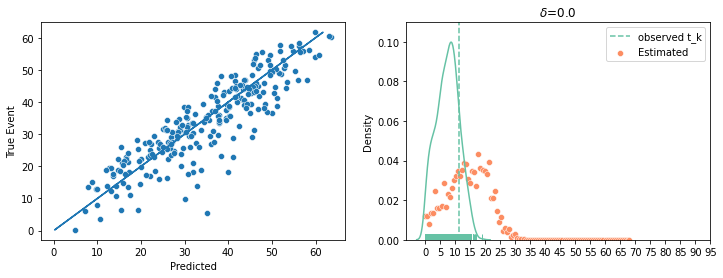

improved
====> Train NLL: 1.564 	 Valid NLL: 1.606 CI: 0.899 event loss: 17.888 	 censoring loss : 0.760 	 Improved: *
epoch61
====> Train NLL: 1.564 	 Valid NLL: 1.606 CI: 0.899 event loss: 18.037 	 censoring loss : 0.715 	 Improved:  
epoch62
====> Train NLL: 1.564 	 Valid NLL: 1.607 CI: 0.899 event loss: 18.443 	 censoring loss : 0.600 	 Improved:  
epoch63
====> Train NLL: 1.563 	 Valid NLL: 1.606 CI: 0.899 event loss: 18.237 	 censoring loss : 0.661 	 Improved:  
epoch64
improved
====> Train NLL: 1.562 	 Valid NLL: 1.606 CI: 0.899 event loss: 18.207 	 censoring loss : 0.644 	 Improved: *
epoch65
improved
====> Train NLL: 1.562 	 Valid NLL: 1.605 CI: 0.899 event loss: 18.128 	 censoring loss : 0.682 	 Improved: *
epoch66
improved
====> Train NLL: 1.561 	 Valid NLL: 1.605 CI: 0.899 event loss: 18.220 	 censoring loss : 0.629 	 Improved: *
epoch67
improved
====> Train NLL: 1.561 	 Valid NLL: 1.604 CI: 0.899 event loss: 18.116 	 censoring loss : 0.669 	 Improved: *
epoch68
====> Train

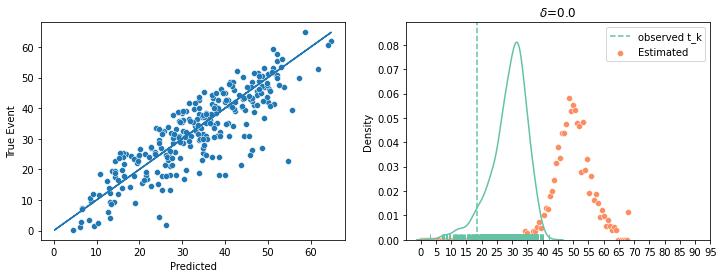

====> Train NLL: 1.559 	 Valid NLL: 1.603 CI: 0.899 event loss: 18.128 	 censoring loss : 0.645 	 Improved:  
epoch71
improved
====> Train NLL: 1.559 	 Valid NLL: 1.603 CI: 0.899 event loss: 17.967 	 censoring loss : 0.693 	 Improved: *
epoch72
improved
====> Train NLL: 1.558 	 Valid NLL: 1.603 CI: 0.899 event loss: 17.983 	 censoring loss : 0.677 	 Improved: *
epoch73
====> Train NLL: 1.558 	 Valid NLL: 1.603 CI: 0.899 event loss: 17.930 	 censoring loss : 0.691 	 Improved:  
epoch74
improved
====> Train NLL: 1.557 	 Valid NLL: 1.603 CI: 0.899 event loss: 17.804 	 censoring loss : 0.737 	 Improved: *
epoch75
improved
====> Train NLL: 1.557 	 Valid NLL: 1.602 CI: 0.899 event loss: 17.896 	 censoring loss : 0.696 	 Improved: *
epoch76
improved
====> Train NLL: 1.557 	 Valid NLL: 1.602 CI: 0.899 event loss: 17.868 	 censoring loss : 0.702 	 Improved: *
epoch77
improved
====> Train NLL: 1.556 	 Valid NLL: 1.602 CI: 0.899 event loss: 17.958 	 censoring loss : 0.666 	 Improved: *
epoch78
im

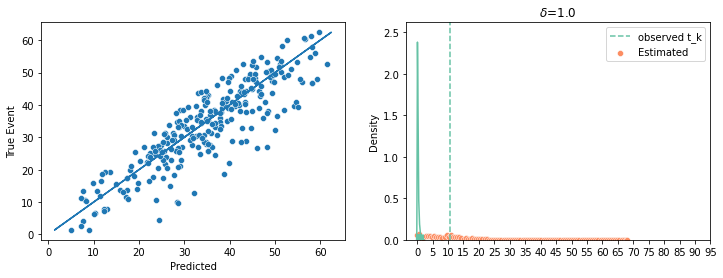

improved
====> Train NLL: 1.555 	 Valid NLL: 1.601 CI: 0.899 event loss: 17.956 	 censoring loss : 0.664 	 Improved: *
epoch81
====> Train NLL: 1.554 	 Valid NLL: 1.602 CI: 0.899 event loss: 18.142 	 censoring loss : 0.611 	 Improved:  
epoch82
====> Train NLL: 1.555 	 Valid NLL: 1.602 CI: 0.899 event loss: 17.892 	 censoring loss : 0.693 	 Improved:  
epoch83
improved
====> Train NLL: 1.554 	 Valid NLL: 1.601 CI: 0.899 event loss: 17.766 	 censoring loss : 0.726 	 Improved: *
epoch84
====> Train NLL: 1.553 	 Valid NLL: 1.601 CI: 0.899 event loss: 17.949 	 censoring loss : 0.656 	 Improved:  
epoch85
====> Train NLL: 1.553 	 Valid NLL: 1.601 CI: 0.899 event loss: 17.843 	 censoring loss : 0.696 	 Improved:  
epoch86
====> Train NLL: 1.552 	 Valid NLL: 1.601 CI: 0.899 event loss: 18.016 	 censoring loss : 0.631 	 Improved:  
epoch87
improved
====> Train NLL: 1.552 	 Valid NLL: 1.601 CI: 0.899 event loss: 18.194 	 censoring loss : 0.583 	 Improved: *
epoch88
====> Train NLL: 1.552 	 Vali

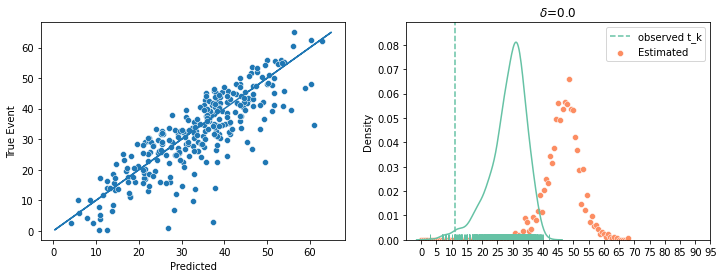

improved
====> Train NLL: 1.551 	 Valid NLL: 1.601 CI: 0.899 event loss: 18.264 	 censoring loss : 0.562 	 Improved: *
epoch91
====> Train NLL: 1.551 	 Valid NLL: 1.601 CI: 0.899 event loss: 17.707 	 censoring loss : 0.724 	 Improved:  
epoch92
improved
====> Train NLL: 1.550 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.784 	 censoring loss : 0.709 	 Improved: *
epoch93
improved
====> Train NLL: 1.550 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.927 	 censoring loss : 0.650 	 Improved: *
epoch94
improved
====> Train NLL: 1.549 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.722 	 censoring loss : 0.713 	 Improved: *
epoch95
improved
====> Train NLL: 1.549 	 Valid NLL: 1.600 CI: 0.899 event loss: 18.130 	 censoring loss : 0.583 	 Improved: *
epoch96
improved
====> Train NLL: 1.549 	 Valid NLL: 1.600 CI: 0.899 event loss: 18.083 	 censoring loss : 0.602 	 Improved: *
epoch97
improved
====> Train NLL: 1.549 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.953 	 censoring loss : 0.639 	 Improved: *
e

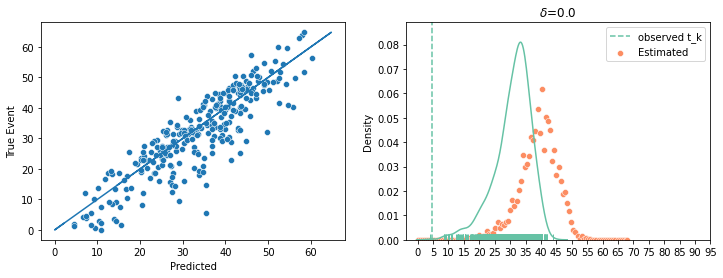

====> Train NLL: 1.548 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.037 	 censoring loss : 0.598 	 Improved:  
epoch101
====> Train NLL: 1.547 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.770 	 censoring loss : 0.683 	 Improved:  
epoch102
improved
====> Train NLL: 1.547 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.739 	 censoring loss : 0.695 	 Improved: *
epoch103
====> Train NLL: 1.547 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.821 	 censoring loss : 0.670 	 Improved:  
epoch104
improved
====> Train NLL: 1.547 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.723 	 censoring loss : 0.703 	 Improved: *
epoch105
improved
====> Train NLL: 1.547 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.899 	 censoring loss : 0.634 	 Improved: *
epoch106
====> Train NLL: 1.546 	 Valid NLL: 1.600 CI: 0.899 event loss: 18.030 	 censoring loss : 0.608 	 Improved:  
epoch107
====> Train NLL: 1.545 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.061 	 censoring loss : 0.592 	 Improved:  
epoch108
====> Train NLL: 1.54

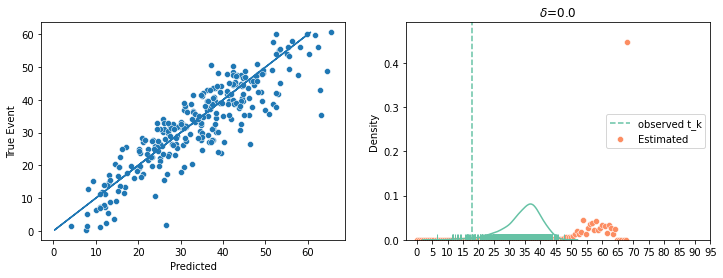

====> Train NLL: 1.545 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.107 	 censoring loss : 0.580 	 Improved:  
epoch111
====> Train NLL: 1.545 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.997 	 censoring loss : 0.604 	 Improved:  
epoch112
improved
====> Train NLL: 1.544 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.891 	 censoring loss : 0.635 	 Improved: *
epoch113
====> Train NLL: 1.544 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.050 	 censoring loss : 0.587 	 Improved:  
epoch114
improved
====> Train NLL: 1.544 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.854 	 censoring loss : 0.650 	 Improved: *
epoch115
====> Train NLL: 1.543 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.004 	 censoring loss : 0.606 	 Improved:  
epoch116
====> Train NLL: 1.543 	 Valid NLL: 1.600 CI: 0.899 event loss: 18.234 	 censoring loss : 0.542 	 Improved:  
epoch117
====> Train NLL: 1.543 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.074 	 censoring loss : 0.586 	 Improved:  
epoch118
====> Train NLL: 1.543 	 Valid

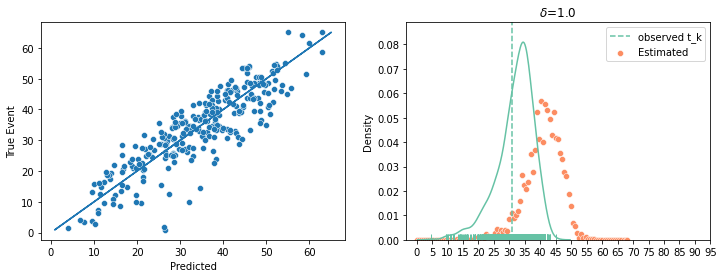

improved
====> Train NLL: 1.542 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.716 	 censoring loss : 0.694 	 Improved: *
epoch121
====> Train NLL: 1.542 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.864 	 censoring loss : 0.651 	 Improved:  
epoch122
====> Train NLL: 1.542 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.037 	 censoring loss : 0.592 	 Improved:  
epoch123
====> Train NLL: 1.541 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.660 	 censoring loss : 0.734 	 Improved:  
epoch124
====> Train NLL: 1.541 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.655 	 censoring loss : 0.719 	 Improved:  
epoch125
====> Train NLL: 1.541 	 Valid NLL: 1.600 CI: 0.899 event loss: 18.013 	 censoring loss : 0.593 	 Improved:  
epoch126
====> Train NLL: 1.541 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.796 	 censoring loss : 0.657 	 Improved:  
epoch127
====> Train NLL: 1.541 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.013 	 censoring loss : 0.595 	 Improved:  
epoch128
====> Train NLL: 1.540 	 Valid NLL: 1.5

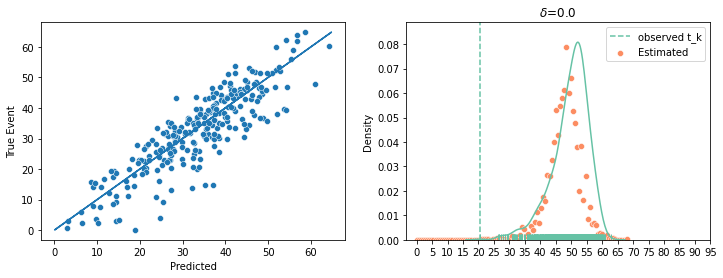

====> Train NLL: 1.540 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.678 	 censoring loss : 0.701 	 Improved:  
epoch131
====> Train NLL: 1.540 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.919 	 censoring loss : 0.621 	 Improved:  
epoch132
improved
====> Train NLL: 1.539 	 Valid NLL: 1.598 CI: 0.899 event loss: 17.987 	 censoring loss : 0.604 	 Improved: *
epoch133
====> Train NLL: 1.539 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.872 	 censoring loss : 0.635 	 Improved:  
epoch134
====> Train NLL: 1.539 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.957 	 censoring loss : 0.605 	 Improved:  
epoch135
====> Train NLL: 1.538 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.061 	 censoring loss : 0.584 	 Improved:  
epoch136
====> Train NLL: 1.538 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.737 	 censoring loss : 0.672 	 Improved:  
epoch137
====> Train NLL: 1.538 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.814 	 censoring loss : 0.662 	 Improved:  
epoch138
====> Train NLL: 1.538 	 Valid NLL: 1.5

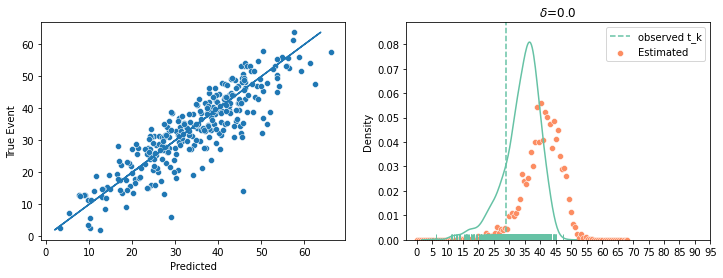

====> Train NLL: 1.538 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.159 	 censoring loss : 0.558 	 Improved:  
epoch141
====> Train NLL: 1.537 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.912 	 censoring loss : 0.619 	 Improved:  
epoch142
====> Train NLL: 1.536 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.024 	 censoring loss : 0.602 	 Improved:  
epoch143
====> Train NLL: 1.537 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.811 	 censoring loss : 0.656 	 Improved:  
epoch144
====> Train NLL: 1.536 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.862 	 censoring loss : 0.657 	 Improved:  
epoch145
====> Train NLL: 1.536 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.922 	 censoring loss : 0.620 	 Improved:  
epoch146
====> Train NLL: 1.536 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.838 	 censoring loss : 0.643 	 Improved:  
epoch147
====> Train NLL: 1.536 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.866 	 censoring loss : 0.632 	 Improved:  
epoch148
====> Train NLL: 1.536 	 Valid NLL: 1.599 CI: 0.

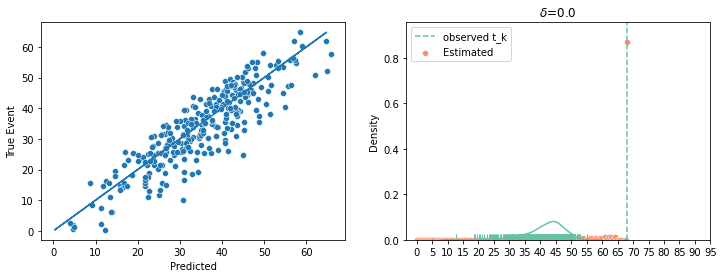

====> Train NLL: 1.535 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.807 	 censoring loss : 0.653 	 Improved:  
epoch151
====> Train NLL: 1.535 	 Valid NLL: 1.601 CI: 0.899 event loss: 18.377 	 censoring loss : 0.510 	 Improved:  
epoch152
====> Train NLL: 1.536 	 Valid NLL: 1.600 CI: 0.899 event loss: 18.000 	 censoring loss : 0.595 	 Improved:  
epoch153
====> Train NLL: 1.534 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.674 	 censoring loss : 0.706 	 Improved:  
epoch154
====> Train NLL: 1.535 	 Valid NLL: 1.599 CI: 0.899 event loss: 17.796 	 censoring loss : 0.669 	 Improved:  
epoch155
====> Train NLL: 1.534 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.816 	 censoring loss : 0.655 	 Improved:  
epoch156
====> Train NLL: 1.534 	 Valid NLL: 1.600 CI: 0.899 event loss: 17.748 	 censoring loss : 0.691 	 Improved:  
epoch157
====> Train NLL: 1.534 	 Valid NLL: 1.599 CI: 0.899 event loss: 18.052 	 censoring loss : 0.579 	 Improved:  
epoch158


KeyboardInterrupt: 

In [17]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0
    
    print('epoch'+str(epoch))
    improved_str = " "
    encoder.train()
    decoder.train()
    for i, (x, y, e) in enumerate(pair1):
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        z = encoder(x)
        p_raw = decoder(z)
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + lambda_*loss_est
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-3)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-3)

        train_loss += loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        
        opt_enc.step()  
        opt_dec.step()  
            

    
    encoder.eval()
    decoder.eval()
#     valid_e_loss, valid_c_loss = 0, 0
#     valid_NLL_loss, valid_est_loss = 0, 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)        
        z = encoder(x)
#         t_hat = decoder(z)
#         hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
#         closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
#         eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        p_raw = decoder(z)
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + lambda_*loss_est
        
        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
                
        valid_pred_t.append(t_wa_hat.squeeze())
        valid_t.append(y.squeeze())
        valid_e.append(e.squeeze())
    
    # concatenate all the validation results
    valid_e = torch.cat(valid_e)
    valid_t = torch.cat(valid_t)
    valid_pred_t = torch.cat(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t)[0]
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 1
    if (best_valid_CI < valid_CI):
        save_model += 1
        
    if epoch % 10 == 0:
        
        subj = np.random.choice(len(e))
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)

        sns.scatterplot(t_wa_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu())
        plt.plot(y[e==1].cpu(), y[e==1].cpu())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        subj = np.random.choice(len(e))
        plt.subplot(1, 2, 2)

        plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw[subj,:].cpu().detach().numpy(), label='Estimated', color=pred_color)
        sample_x = x[subj,:].cpu().numpy()
        sample_x_new = sample_x.copy()
        for idx in cts_idx:
            sample_x_new[idx] = (sample_x[idx]*train_std[idx]) + train_mean[idx]

        true_T = single_subj_true_dist_cox_gompertz(sample_x_new, true_beta)['T']
        sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(e[subj].item()))
        plt.show()
        
    if save_model >1:
        print('improved')
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
        
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

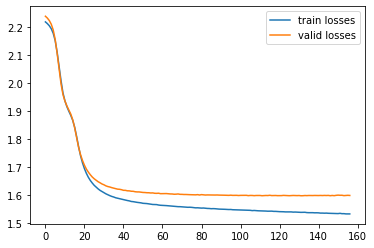

In [18]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
# plt.xlim(0,150)
plt.legend()


In [20]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    z = encoder(x)
#     t_hat = decoder(z)
#     hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
#     closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
#     eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
    p_raw = decoder(z)

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # weighted average
    t_wa_hat = wt_avg(p_raw, tt)

    eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + lambda_*loss_est

    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()
    
    valid_pred_t.append(t_wa_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())

print(valid_e_loss)


119919.41940809536


Text(0, 0.5, 'True Event')

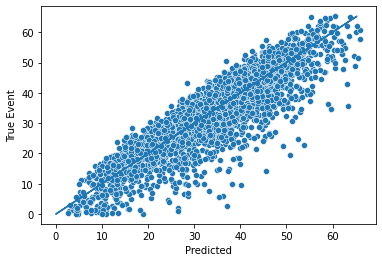

In [21]:
valid_e = torch.cat(valid_e)
valid_t = torch.cat(valid_t)
valid_pred_t = torch.cat(valid_pred_t)


subj = np.random.choice(len(valid_e))
plt.figure()

sns.scatterplot(valid_pred_t[valid_e==1].cpu().detach().numpy().squeeze(), valid_t[valid_e==1].cpu())
plt.plot(valid_t[valid_e==1].cpu(), valid_t[valid_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')


In [28]:
# single head attention
# https://github.com/QiangAIResearcher/sahp_repo/blob/master/models/attention/single.py

import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import numpy as np

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def forward(self, query, key, value, mask=None, dropout=None):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        scores = torch.exp(torch.matmul(query, key.transpose(-2, -1))) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn
    
    
class MultiHeadedAttention(nn.Module):
    """
    Take in models size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model, bias=True) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model, bias=True)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # the same mask applies to all heads
            # unsqueeze Returns a new tensor with a dimension of size one
            # inserted at the specified position.
            mask = mask.unsqueeze(1)

        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention.forward(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

## define MLP network

In [52]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP_cts(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP_cts, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return z

    
class DecMLP_clf(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(DecMLP_clf, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [53]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
t = train['t']
ncov = X.shape[1]
covList = np.arange(ncov)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

trainData = SimpleDataset(X, t, train['e'], transform=True, mean=mean, std = std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(test['x'], test['t'], test['e'], transform=True, mean=mean, std = std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

NameError: name 'train' is not defined

In [51]:
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP_cts(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_only.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_only.pt'

print(encoder, decoder)

NameError: name 'X' is not defined

Text(0, 0.5, 'True Event')

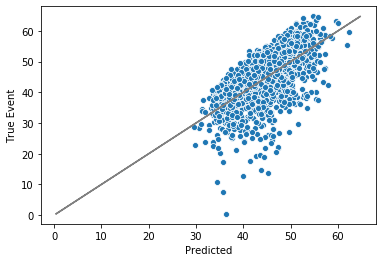

In [136]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))



Text(0, 0.5, 'True Event')

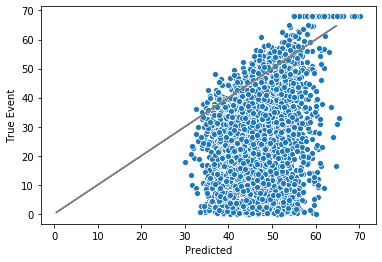

In [137]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')


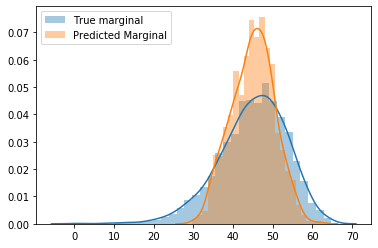

In [138]:
sns.distplot(y[e==1], label = 'True marginal')
sns.distplot(t_hat[e==1].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

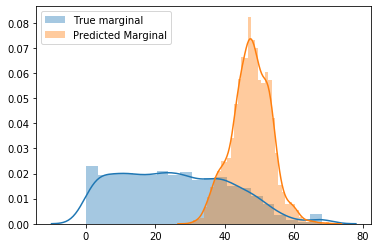

In [140]:
sns.distplot(y[e==0], label = 'True marginal')
sns.distplot(t_hat[e==0].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

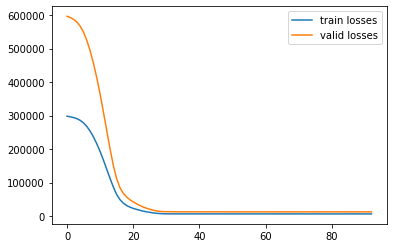

In [141]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [73]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
z = encoder(x.to(device).float())
t = decoder(z)

calculate_KS_Div((x[test['e']==1,:]*std)+mean, p_raw[test['e']==1,:], tt), calculate_KS_Div((x*std)+mean, p_raw, tt)


NameError: name 'calculate_KS_Div' is not defined

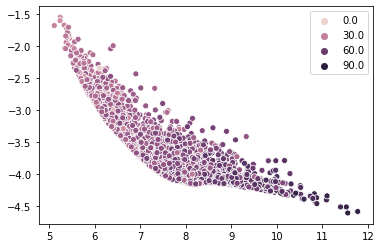

In [142]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


(tensor(55.4096), tensor(1))

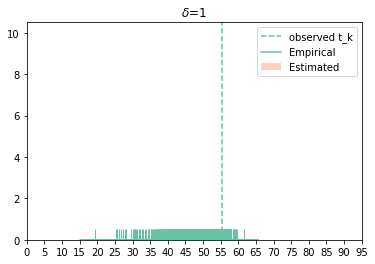

In [156]:
y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
# y_cat = batch_t_categorize(y, e, tt)
x = (torch.tensor(test['x']).to(device).float()-mean)/std

subj = 6
x_new = x[subj,:].expand(100,-1)
z = encoder(x_new.to(device).float())
t_hat = decoder(z)


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')
sns.distplot(t_hat.detach().numpy(), label='Estimated', color=pred_color)
# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]



## select pairs with data loader

In [159]:
for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
    # PAIR 1 need to be non-censored ? +(1-e1)
    # y1 should not equal to y2
    delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
#     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
    x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
    x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]
    
    batch_label = 1*(y1 > y2)
    batch_pair = torch.cat([x1, x2],axis = 1)
    break

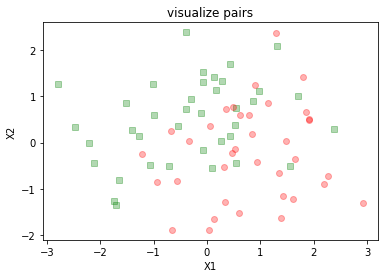

In [160]:
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)
_ = plt.title('visualize pairs')
_ = plt.plot(batch_pair[pos_idx,0].tolist(),batch_pair[pos_idx,ncov].tolist(),'sg',alpha=.3, label='T(X1)>T(X2)')
_ = plt.plot(batch_pair[neg_idx,0].tolist(),batch_pair[neg_idx,ncov].tolist(),'or',alpha=.3, label='T(X1)<T(X2)')

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

## Define the network

In [177]:
# if retrain encoder, decoder
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)



hidden_layer=[128,128]
epochs = 1000
device = 'cpu'
# input is pair of X
clf = SimpleMLP(input_size = 2*zdim, output_size = 1, h_dim=hidden_layer)

# define optimizer
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# define weight
ctr_wt = 1
clf_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'clf_'+str(ctr_wt)+'.pt'

enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_'+str(ctr_wt)+'.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_'+str(ctr_wt)+'.pt'
print(encoder, decoder)
print(clf)


EncMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (out): Sigmoid()
)


In [178]:
def single_patient_true_surv_cox_gompertz(covariates, beta_linear = np.array([0.15,0.001]),lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    St = np.exp(-(lambda_/alpha_)*(np.exp(alpha_*tt)-1)*np.exp(np.dot(X,beta_linear)))
    return({"St": St})

# KS divergence
def KS_D(F1, F2, tt):
    diff_list = np.abs((np.ones(len(tt))-F1)-(np.ones(len(tt))-F2))
    return(tt[np.argmax(diff_list)], np.max(diff_list), diff_list)

def calculate_KS_Div(x, p_raw, tt):
    KS_list = []
    for subj in np.arange(p_raw.shape[0]):
        true_St=single_patient_true_surv_cox_gompertz(covariates=x[subj,:].numpy(), tt=tt)['St']
        St = 1-np.cumsum(p_raw[subj,:].detach().numpy())
        diff_t, diff_D, diff_list = KS_D(St, true_St, tt)
        KS_list.append(diff_D)

    return np.mean(KS_list)

epoch1
====> Train Loss: 598019.7891 	 NLL: 598019.0964 	 contrastive loss: 0.6927
====> Valid NLL loss: 597951.3697 	Improved: *
epoch2
====> Train Loss: 594047.0299 	 NLL: 594046.3373 	 contrastive loss: 0.6926
====> Valid NLL loss: 593967.2894 	Improved: *
epoch3
====> Train Loss: 589606.2762 	 NLL: 589605.5859 	 contrastive loss: 0.6904
====> Valid NLL loss: 588863.4839 	Improved: *
epoch4
====> Train Loss: 583396.0191 	 NLL: 583395.3324 	 contrastive loss: 0.6866
====> Valid NLL loss: 581354.4926 	Improved: *
epoch5
====> Train Loss: 574136.1998 	 NLL: 574135.5143 	 contrastive loss: 0.6854
====> Valid NLL loss: 570171.2735 	Improved: *
epoch6
====> Train Loss: 560883.1960 	 NLL: 560882.5164 	 contrastive loss: 0.6796
====> Valid NLL loss: 554962.1832 	Improved: *
epoch7
====> Train Loss: 543442.8007 	 NLL: 543442.1210 	 contrastive loss: 0.6797
====> Valid NLL loss: 535245.0540 	Improved: *
epoch8
====> Train Loss: 521175.5906 	 NLL: 521174.9125 	 contrastive loss: 0.6781
====> V

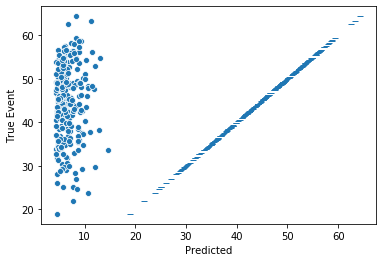

====> Valid NLL loss: 443585.2255 	Improved: *
epoch11
====> Train Loss: 420164.6468 	 NLL: 420163.9572 	 contrastive loss: 0.6896
====> Valid NLL loss: 401766.9092 	Improved: *
epoch12
====> Train Loss: 374934.3770 	 NLL: 374933.6866 	 contrastive loss: 0.6904
====> Valid NLL loss: 354130.7078 	Improved: *
epoch13
====> Train Loss: 324830.3126 	 NLL: 324829.6137 	 contrastive loss: 0.6989
====> Valid NLL loss: 301821.9226 	Improved: *
epoch14
====> Train Loss: 270542.3757 	 NLL: 270541.6795 	 contrastive loss: 0.6961
====> Valid NLL loss: 246452.3501 	Improved: *
epoch15
====> Train Loss: 214540.7464 	 NLL: 214540.0440 	 contrastive loss: 0.7024
====> Valid NLL loss: 189844.9166 	Improved: *
epoch16
====> Train Loss: 159721.3941 	 NLL: 159720.7027 	 contrastive loss: 0.6914
====> Valid NLL loss: 136861.0703 	Improved: *
epoch17
====> Train Loss: 111336.2215 	 NLL: 111335.5248 	 contrastive loss: 0.6967
====> Valid NLL loss: 92870.5845 	Improved: *
epoch18
====> Train Loss: 75672.8004 

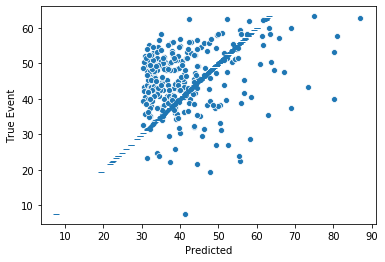

====> Valid NLL loss: 42338.0001 	Improved: *
epoch21
====> Train Loss: 40003.0587 	 NLL: 40002.4144 	 contrastive loss: 0.6443
====> Valid NLL loss: 35756.5713 	Improved: *
epoch22
====> Train Loss: 34202.7668 	 NLL: 34202.1356 	 contrastive loss: 0.6312
====> Valid NLL loss: 30925.7458 	Improved: *
epoch23
====> Train Loss: 29414.3942 	 NLL: 29413.7891 	 contrastive loss: 0.6052
====> Valid NLL loss: 26442.2598 	Improved: *
epoch24
====> Train Loss: 25343.0441 	 NLL: 25342.4597 	 contrastive loss: 0.5843
====> Valid NLL loss: 22554.2147 	Improved: *
epoch25
====> Train Loss: 21688.4007 	 NLL: 21687.8271 	 contrastive loss: 0.5736
====> Valid NLL loss: 19419.3841 	Improved: *
epoch26
====> Train Loss: 18724.4195 	 NLL: 18723.8701 	 contrastive loss: 0.5494
====> Valid NLL loss: 16684.5260 	Improved: *
epoch27
====> Train Loss: 16354.2513 	 NLL: 16353.7213 	 contrastive loss: 0.5300
====> Valid NLL loss: 14846.8080 	Improved: *
epoch28
====> Train Loss: 14719.5111 	 NLL: 14718.9951 	 c

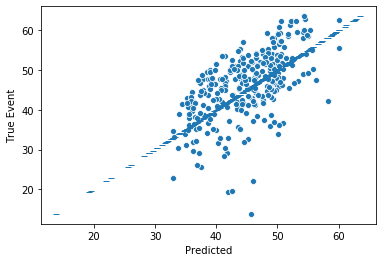

====> Valid NLL loss: 13177.1507 	Improved: *
epoch31
====> Train Loss: 13505.7222 	 NLL: 13505.2616 	 contrastive loss: 0.4606
====> Valid NLL loss: 13094.6500 	Improved: *
epoch32
====> Train Loss: 13543.8405 	 NLL: 13543.3762 	 contrastive loss: 0.4643
====> Valid NLL loss: 13019.2507 	Improved: *
epoch33
====> Train Loss: 13423.6661 	 NLL: 13423.2327 	 contrastive loss: 0.4335
====> Valid NLL loss: 12920.3799 	Improved: *
epoch34
====> Train Loss: 13384.7042 	 NLL: 13384.2586 	 contrastive loss: 0.4455
====> Valid NLL loss: 12925.0167 	Improved:  
epoch35
====> Train Loss: 13342.0673 	 NLL: 13341.6349 	 contrastive loss: 0.4324
====> Valid NLL loss: 12906.3424 	Improved: *
epoch36
====> Train Loss: 13323.9790 	 NLL: 13323.5160 	 contrastive loss: 0.4630
====> Valid NLL loss: 12832.8989 	Improved: *
epoch37
====> Train Loss: 13274.1347 	 NLL: 13273.6813 	 contrastive loss: 0.4534
====> Valid NLL loss: 12865.5729 	Improved:  
epoch38
====> Train Loss: 13272.0883 	 NLL: 13271.6599 	 c

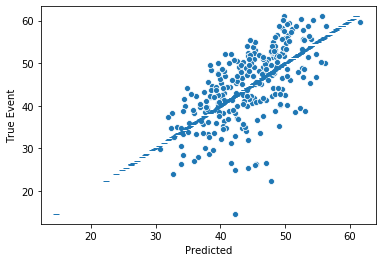

====> Valid NLL loss: 12859.1196 	Improved:  
epoch41
====> Train Loss: 13220.9757 	 NLL: 13220.5458 	 contrastive loss: 0.4299
====> Valid NLL loss: 12951.9346 	Improved:  
epoch42
====> Train Loss: 13225.6749 	 NLL: 13225.2266 	 contrastive loss: 0.4483
====> Valid NLL loss: 12818.2862 	Improved: *
epoch43
====> Train Loss: 13279.9613 	 NLL: 13279.5194 	 contrastive loss: 0.4420
====> Valid NLL loss: 12762.1877 	Improved: *
epoch44
====> Train Loss: 13176.2616 	 NLL: 13175.8109 	 contrastive loss: 0.4507
====> Valid NLL loss: 12773.9132 	Improved:  
epoch45
====> Train Loss: 13170.0187 	 NLL: 13169.5752 	 contrastive loss: 0.4436
====> Valid NLL loss: 12824.4867 	Improved:  
epoch46
====> Train Loss: 13168.9664 	 NLL: 13168.5430 	 contrastive loss: 0.4234
====> Valid NLL loss: 12765.5885 	Improved:  
epoch47
====> Train Loss: 13148.9148 	 NLL: 13148.4844 	 contrastive loss: 0.4304
====> Valid NLL loss: 12794.9337 	Improved:  
epoch48
====> Train Loss: 13143.3875 	 NLL: 13142.9708 	 c

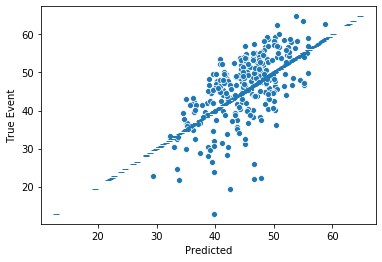

====> Valid NLL loss: 12835.9686 	Improved:  
epoch51
====> Train Loss: 13138.1506 	 NLL: 13137.7252 	 contrastive loss: 0.4254
====> Valid NLL loss: 12725.9454 	Improved: *
epoch52
====> Train Loss: 13111.8537 	 NLL: 13111.4002 	 contrastive loss: 0.4535
====> Valid NLL loss: 12722.2071 	Improved: *
epoch53
====> Train Loss: 13111.7381 	 NLL: 13111.2930 	 contrastive loss: 0.4451
====> Valid NLL loss: 12729.1283 	Improved:  
epoch54
====> Train Loss: 13132.6492 	 NLL: 13132.2242 	 contrastive loss: 0.4250
====> Valid NLL loss: 12771.4539 	Improved:  
epoch55
====> Train Loss: 13107.8243 	 NLL: 13107.3813 	 contrastive loss: 0.4430
====> Valid NLL loss: 12721.1712 	Improved: *
epoch56
====> Train Loss: 13135.3618 	 NLL: 13134.9311 	 contrastive loss: 0.4307
====> Valid NLL loss: 12738.0711 	Improved:  
epoch57
====> Train Loss: 13138.6031 	 NLL: 13138.1878 	 contrastive loss: 0.4153
====> Valid NLL loss: 12754.5380 	Improved:  
epoch58
====> Train Loss: 13107.0987 	 NLL: 13106.6747 	 c

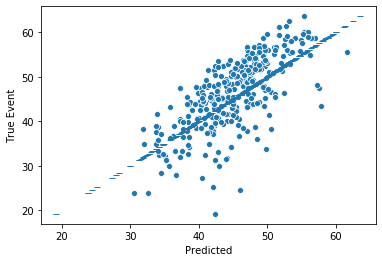

====> Valid NLL loss: 12722.0240 	Improved:  
epoch61
====> Train Loss: 13150.5374 	 NLL: 13150.1199 	 contrastive loss: 0.4175
====> Valid NLL loss: 12868.2655 	Improved:  
epoch62
====> Train Loss: 13128.3587 	 NLL: 13127.9362 	 contrastive loss: 0.4225
====> Valid NLL loss: 12835.4688 	Improved:  
epoch63
====> Train Loss: 13156.6407 	 NLL: 13156.1849 	 contrastive loss: 0.4558
====> Valid NLL loss: 12775.3208 	Improved:  
epoch64
====> Train Loss: 13116.1991 	 NLL: 13115.7611 	 contrastive loss: 0.4380
====> Valid NLL loss: 12756.9529 	Improved:  
epoch65
====> Train Loss: 13071.6303 	 NLL: 13071.1878 	 contrastive loss: 0.4425
====> Valid NLL loss: 12811.6858 	Improved:  
epoch66
====> Train Loss: 13142.0779 	 NLL: 13141.6618 	 contrastive loss: 0.4161
====> Valid NLL loss: 12745.9660 	Improved:  
epoch67
====> Train Loss: 13093.7162 	 NLL: 13093.2862 	 contrastive loss: 0.4299
====> Valid NLL loss: 12748.4260 	Improved:  
epoch68
====> Train Loss: 13091.8983 	 NLL: 13091.4484 	 c

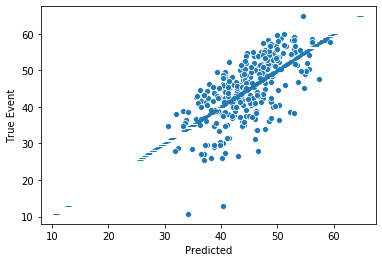

====> Valid NLL loss: 12731.0398 	Improved:  
epoch71
====> Train Loss: 13077.5687 	 NLL: 13077.1287 	 contrastive loss: 0.4400
====> Valid NLL loss: 12737.7116 	Improved:  
epoch72
====> Train Loss: 13076.2160 	 NLL: 13075.7758 	 contrastive loss: 0.4402
====> Valid NLL loss: 12770.8685 	Improved:  
epoch73
====> Train Loss: 13073.7884 	 NLL: 13073.3466 	 contrastive loss: 0.4418
====> Valid NLL loss: 12727.8262 	Improved:  
epoch74
====> Train Loss: 13077.3815 	 NLL: 13076.9625 	 contrastive loss: 0.4190
====> Valid NLL loss: 12765.2236 	Improved:  
epoch75
====> Train Loss: 13087.9939 	 NLL: 13087.5644 	 contrastive loss: 0.4295
====> Valid NLL loss: 12810.7804 	Improved:  
epoch76
====> Train Loss: 13104.9230 	 NLL: 13104.4807 	 contrastive loss: 0.4422
====> Valid NLL loss: 12771.3601 	Improved:  
epoch77
====> Train Loss: 13127.6548 	 NLL: 13127.2184 	 contrastive loss: 0.4364
====> Valid NLL loss: 12727.9086 	Improved:  
epoch78
====> Train Loss: 13111.4183 	 NLL: 13110.9807 	 c

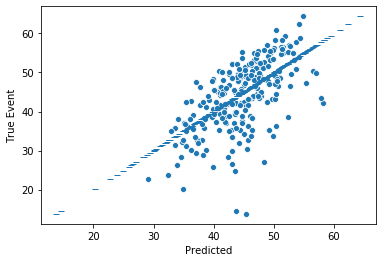

====> Valid NLL loss: 12724.3933 	Improved:  
epoch81
====> Train Loss: 13061.8460 	 NLL: 13061.3974 	 contrastive loss: 0.4486
====> Valid NLL loss: 12731.6868 	Improved:  
epoch82
====> Train Loss: 13056.2522 	 NLL: 13055.8364 	 contrastive loss: 0.4159
====> Valid NLL loss: 12730.0449 	Improved:  
epoch83
====> Train Loss: 13086.2539 	 NLL: 13085.8219 	 contrastive loss: 0.4320
====> Valid NLL loss: 12722.6596 	Improved:  
epoch84
====> Train Loss: 13057.1914 	 NLL: 13056.7831 	 contrastive loss: 0.4083
====> Valid NLL loss: 12759.3006 	Improved:  
epoch85
====> Train Loss: 13045.6148 	 NLL: 13045.1647 	 contrastive loss: 0.4502
====> Valid NLL loss: 12743.8962 	Improved:  
epoch86
====> Train Loss: 13049.2473 	 NLL: 13048.8090 	 contrastive loss: 0.4383
====> Valid NLL loss: 12722.0114 	Improved:  
epoch87
====> Train Loss: 13060.7456 	 NLL: 13060.3080 	 contrastive loss: 0.4376
====> Valid NLL loss: 12770.5181 	Improved:  
epoch88
====> Train Loss: 13063.7471 	 NLL: 13063.3050 	 c

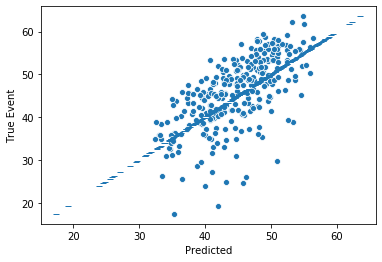

====> Valid NLL loss: 12769.4634 	Improved:  
epoch91
====> Train Loss: 13047.0298 	 NLL: 13046.5940 	 contrastive loss: 0.4358
====> Valid NLL loss: 12713.6341 	Improved: *
epoch92
====> Train Loss: 13052.9826 	 NLL: 13052.5488 	 contrastive loss: 0.4339
====> Valid NLL loss: 12711.4939 	Improved: *
epoch93
====> Train Loss: 13053.4693 	 NLL: 13053.0642 	 contrastive loss: 0.4051
====> Valid NLL loss: 12713.3494 	Improved:  
epoch94
====> Train Loss: 13044.3930 	 NLL: 13043.9609 	 contrastive loss: 0.4321
====> Valid NLL loss: 12812.6387 	Improved:  
epoch95
====> Train Loss: 13067.8431 	 NLL: 13067.4030 	 contrastive loss: 0.4401
====> Valid NLL loss: 12730.2543 	Improved:  
epoch96
====> Train Loss: 13060.8590 	 NLL: 13060.4204 	 contrastive loss: 0.4385
====> Valid NLL loss: 12716.9933 	Improved:  
epoch97
====> Train Loss: 13056.2686 	 NLL: 13055.8173 	 contrastive loss: 0.4512
====> Valid NLL loss: 12733.1271 	Improved:  
epoch98
====> Train Loss: 13063.3422 	 NLL: 13062.9008 	 c

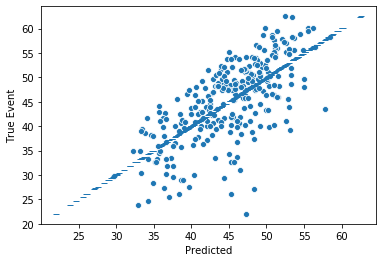

====> Valid NLL loss: 12733.7970 	Improved:  
epoch101
====> Train Loss: 13052.4548 	 NLL: 13052.0503 	 contrastive loss: 0.4045
====> Valid NLL loss: 12714.1316 	Improved:  
epoch102
====> Train Loss: 13061.8613 	 NLL: 13061.4265 	 contrastive loss: 0.4348
====> Valid NLL loss: 12719.1677 	Improved:  
epoch103
====> Train Loss: 13039.1456 	 NLL: 13038.7035 	 contrastive loss: 0.4420
====> Valid NLL loss: 12781.1753 	Improved:  
epoch104
====> Train Loss: 13048.1370 	 NLL: 13047.6974 	 contrastive loss: 0.4397
====> Valid NLL loss: 12748.8731 	Improved:  
epoch105
====> Train Loss: 13049.8632 	 NLL: 13049.4425 	 contrastive loss: 0.4207
====> Valid NLL loss: 12746.8474 	Improved:  
epoch106
====> Train Loss: 13049.5661 	 NLL: 13049.1342 	 contrastive loss: 0.4319
====> Valid NLL loss: 12719.6019 	Improved:  
epoch107
====> Train Loss: 13087.0904 	 NLL: 13086.6635 	 contrastive loss: 0.4269
====> Valid NLL loss: 12740.0475 	Improved:  
epoch108
====> Train Loss: 13051.0923 	 NLL: 13050.

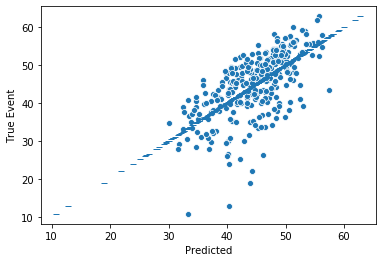

====> Valid NLL loss: 12729.3689 	Improved:  
epoch111
====> Train Loss: 13035.5777 	 NLL: 13035.1185 	 contrastive loss: 0.4592
====> Valid NLL loss: 12740.4515 	Improved:  
epoch112
====> Train Loss: 13060.3620 	 NLL: 13059.9474 	 contrastive loss: 0.4146
====> Valid NLL loss: 12729.8343 	Improved:  
epoch113
====> Train Loss: 13088.5834 	 NLL: 13088.1448 	 contrastive loss: 0.4386
====> Valid NLL loss: 13125.3151 	Improved:  
epoch114
====> Train Loss: 13135.6957 	 NLL: 13135.2858 	 contrastive loss: 0.4099
====> Valid NLL loss: 12805.1062 	Improved:  
epoch115
====> Train Loss: 13060.0642 	 NLL: 13059.6227 	 contrastive loss: 0.4415
====> Valid NLL loss: 12755.2794 	Improved:  
epoch116
====> Train Loss: 13051.0426 	 NLL: 13050.5870 	 contrastive loss: 0.4556
====> Valid NLL loss: 12731.2745 	Improved:  
epoch117
====> Train Loss: 13027.8330 	 NLL: 13027.3883 	 contrastive loss: 0.4447
====> Valid NLL loss: 12757.4770 	Improved:  
epoch118
====> Train Loss: 13051.4616 	 NLL: 13051.

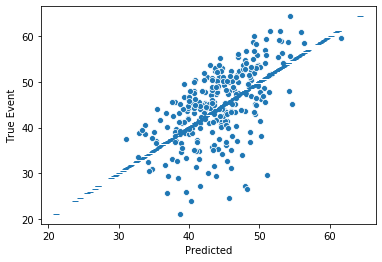

====> Valid NLL loss: 12738.1924 	Improved:  
epoch121
====> Train Loss: 13024.7337 	 NLL: 13024.2969 	 contrastive loss: 0.4368
====> Valid NLL loss: 12762.4697 	Improved:  
epoch122
====> Train Loss: 13036.5841 	 NLL: 13036.1480 	 contrastive loss: 0.4360
====> Valid NLL loss: 12733.9582 	Improved:  
epoch123
====> Train Loss: 13024.5396 	 NLL: 13024.1286 	 contrastive loss: 0.4110
====> Valid NLL loss: 12761.9589 	Improved:  
epoch124
====> Train Loss: 13021.1104 	 NLL: 13020.6761 	 contrastive loss: 0.4343
====> Valid NLL loss: 12748.3884 	Improved:  
epoch125
====> Train Loss: 13022.3729 	 NLL: 13021.9593 	 contrastive loss: 0.4136
====> Valid NLL loss: 12756.8110 	Improved:  
epoch126
====> Train Loss: 13015.0091 	 NLL: 13014.5807 	 contrastive loss: 0.4284
====> Valid NLL loss: 12719.7755 	Improved:  
epoch127
====> Train Loss: 13048.8858 	 NLL: 13048.4436 	 contrastive loss: 0.4422
====> Valid NLL loss: 12731.9616 	Improved:  
epoch128
====> Train Loss: 13041.4858 	 NLL: 13041.

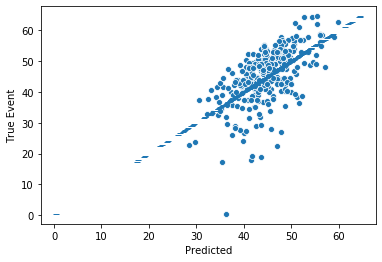

====> Valid NLL loss: 12784.7861 	Improved:  
epoch131
====> Train Loss: 13067.9203 	 NLL: 13067.4851 	 contrastive loss: 0.4352
====> Valid NLL loss: 12814.3798 	Improved:  
epoch132
====> Train Loss: 13030.2880 	 NLL: 13029.8742 	 contrastive loss: 0.4138
====> Valid NLL loss: 12788.0919 	Improved:  
epoch133
====> Train Loss: 13038.3311 	 NLL: 13037.8872 	 contrastive loss: 0.4439
====> Valid NLL loss: 12793.5724 	Improved:  
epoch134
====> Train Loss: 13038.9755 	 NLL: 13038.5322 	 contrastive loss: 0.4433
====> Valid NLL loss: 12725.0740 	Improved:  
epoch135
====> Train Loss: 13028.4768 	 NLL: 13028.0335 	 contrastive loss: 0.4433
====> Valid NLL loss: 12747.7600 	Improved:  
epoch136
====> Train Loss: 13008.5013 	 NLL: 13008.0740 	 contrastive loss: 0.4273
====> Valid NLL loss: 12725.5353 	Improved:  
epoch137
====> Train Loss: 13032.9575 	 NLL: 13032.5341 	 contrastive loss: 0.4235
====> Valid NLL loss: 12781.3488 	Improved:  
epoch138
====> Train Loss: 13040.7918 	 NLL: 13040.

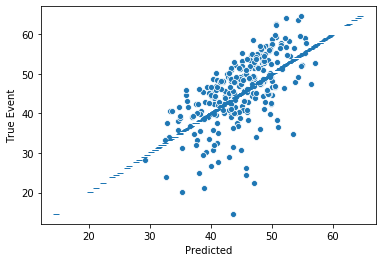

====> Valid NLL loss: 12747.5087 	Improved:  
epoch141
====> Train Loss: 13036.5761 	 NLL: 13036.1351 	 contrastive loss: 0.4410
====> Valid NLL loss: 12747.5475 	Improved:  
epoch142
====> Train Loss: 13012.4228 	 NLL: 13012.0163 	 contrastive loss: 0.4066
====> Valid NLL loss: 12706.6968 	Improved: *
epoch143
====> Train Loss: 13020.8392 	 NLL: 13020.4082 	 contrastive loss: 0.4310
====> Valid NLL loss: 12737.4249 	Improved:  
epoch144
====> Train Loss: 13008.8322 	 NLL: 13008.4056 	 contrastive loss: 0.4266
====> Valid NLL loss: 12711.0038 	Improved:  
epoch145
====> Train Loss: 13015.3056 	 NLL: 13014.8569 	 contrastive loss: 0.4486
====> Valid NLL loss: 12715.6097 	Improved:  
epoch146
====> Train Loss: 13018.3110 	 NLL: 13017.8974 	 contrastive loss: 0.4136
====> Valid NLL loss: 12727.4561 	Improved:  
epoch147
====> Train Loss: 13030.0922 	 NLL: 13029.6383 	 contrastive loss: 0.4539
====> Valid NLL loss: 12740.4881 	Improved:  
epoch148
====> Train Loss: 13026.2466 	 NLL: 13025.

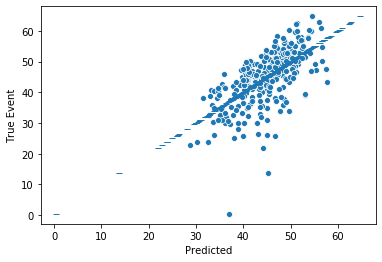

====> Valid NLL loss: 12739.2495 	Improved:  
epoch151
====> Train Loss: 13009.1714 	 NLL: 13008.7278 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.6999 	Improved:  
epoch152
====> Train Loss: 13060.1642 	 NLL: 13059.7434 	 contrastive loss: 0.4208
====> Valid NLL loss: 12724.9632 	Improved:  
epoch153
====> Train Loss: 13043.2361 	 NLL: 13042.8127 	 contrastive loss: 0.4234
====> Valid NLL loss: 12878.1238 	Improved:  
epoch154
====> Train Loss: 13038.3472 	 NLL: 13037.8841 	 contrastive loss: 0.4631
====> Valid NLL loss: 12736.6392 	Improved:  
epoch155
====> Train Loss: 13017.7028 	 NLL: 13017.2534 	 contrastive loss: 0.4494
====> Valid NLL loss: 12838.8231 	Improved:  
epoch156
====> Train Loss: 13043.3878 	 NLL: 13042.9857 	 contrastive loss: 0.4022
====> Valid NLL loss: 12762.7838 	Improved:  
epoch157
====> Train Loss: 13026.9848 	 NLL: 13026.5405 	 contrastive loss: 0.4443
====> Valid NLL loss: 12785.0023 	Improved:  
epoch158
====> Train Loss: 12988.4405 	 NLL: 12988.

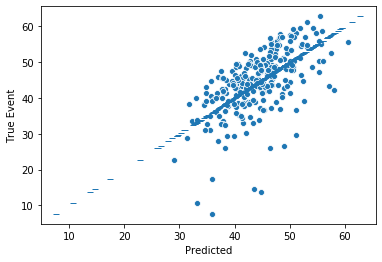

====> Valid NLL loss: 12765.7623 	Improved:  
epoch161
====> Train Loss: 13013.8832 	 NLL: 13013.4626 	 contrastive loss: 0.4206
====> Valid NLL loss: 12757.2912 	Improved:  
epoch162
====> Train Loss: 13026.2607 	 NLL: 13025.8136 	 contrastive loss: 0.4471
====> Valid NLL loss: 12738.8841 	Improved:  
epoch163
====> Train Loss: 13058.5776 	 NLL: 13058.1477 	 contrastive loss: 0.4299
====> Valid NLL loss: 12731.0131 	Improved:  
epoch164
====> Train Loss: 13007.3353 	 NLL: 13006.8815 	 contrastive loss: 0.4538
====> Valid NLL loss: 12741.7628 	Improved:  
epoch165
====> Train Loss: 13021.3738 	 NLL: 13020.9298 	 contrastive loss: 0.4441
====> Valid NLL loss: 12733.1938 	Improved:  
epoch166
====> Train Loss: 13027.9780 	 NLL: 13027.5494 	 contrastive loss: 0.4286
====> Valid NLL loss: 12720.6022 	Improved:  
epoch167
====> Train Loss: 13004.0276 	 NLL: 13003.5837 	 contrastive loss: 0.4439
====> Valid NLL loss: 12743.5851 	Improved:  
epoch168
====> Train Loss: 13005.4663 	 NLL: 13005.

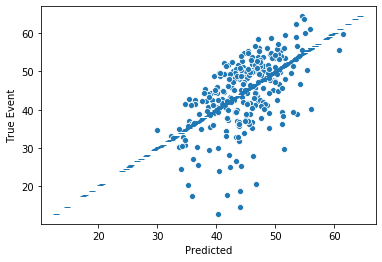

====> Valid NLL loss: 12713.8450 	Improved:  
epoch171
====> Train Loss: 13000.1278 	 NLL: 12999.7087 	 contrastive loss: 0.4192
====> Valid NLL loss: 12710.7473 	Improved:  
epoch172
====> Train Loss: 13013.5941 	 NLL: 13013.1637 	 contrastive loss: 0.4304
====> Valid NLL loss: 12810.1296 	Improved:  
epoch173
====> Train Loss: 13042.4473 	 NLL: 13041.9987 	 contrastive loss: 0.4487
====> Valid NLL loss: 12745.7766 	Improved:  
epoch174
====> Train Loss: 13021.0746 	 NLL: 13020.6147 	 contrastive loss: 0.4599
====> Valid NLL loss: 12714.2188 	Improved:  
epoch175
====> Train Loss: 13013.7596 	 NLL: 13013.3285 	 contrastive loss: 0.4311
====> Valid NLL loss: 12722.9236 	Improved:  
epoch176
====> Train Loss: 12984.9184 	 NLL: 12984.4757 	 contrastive loss: 0.4427
====> Valid NLL loss: 12804.7836 	Improved:  
epoch177
====> Train Loss: 13002.6678 	 NLL: 13002.2197 	 contrastive loss: 0.4481
====> Valid NLL loss: 12744.5712 	Improved:  
epoch178
====> Train Loss: 13009.8444 	 NLL: 13009.

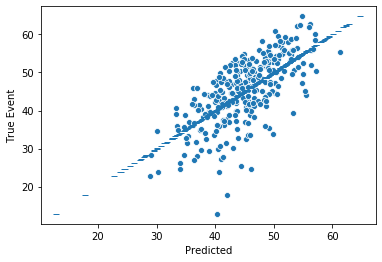

====> Valid NLL loss: 12734.3433 	Improved:  
epoch181
====> Train Loss: 13011.0712 	 NLL: 13010.6276 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.3336 	Improved:  
epoch182
====> Train Loss: 13037.0578 	 NLL: 13036.6320 	 contrastive loss: 0.4258
====> Valid NLL loss: 12747.2819 	Improved:  
epoch183
====> Train Loss: 12997.5006 	 NLL: 12997.0799 	 contrastive loss: 0.4207
====> Valid NLL loss: 12714.1267 	Improved:  
epoch184
====> Train Loss: 13018.0572 	 NLL: 13017.6178 	 contrastive loss: 0.4393
====> Valid NLL loss: 12744.8746 	Improved:  
epoch185
====> Train Loss: 13009.0862 	 NLL: 13008.6630 	 contrastive loss: 0.4232
====> Valid NLL loss: 12757.7515 	Improved:  
epoch186
====> Train Loss: 12998.8919 	 NLL: 12998.4601 	 contrastive loss: 0.4317
====> Valid NLL loss: 12741.2308 	Improved:  
epoch187
====> Train Loss: 12994.5166 	 NLL: 12994.0951 	 contrastive loss: 0.4215
====> Valid NLL loss: 12772.4112 	Improved:  
epoch188
====> Train Loss: 13004.3899 	 NLL: 13003.

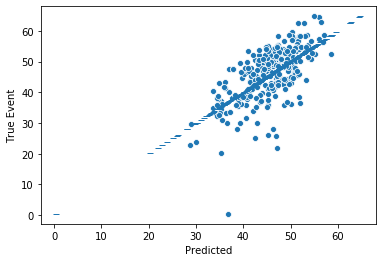

====> Valid NLL loss: 12744.9768 	Improved:  
epoch191
====> Train Loss: 13014.8920 	 NLL: 13014.4679 	 contrastive loss: 0.4241
====> Valid NLL loss: 12722.2676 	Improved:  
epoch192
====> Train Loss: 13007.6557 	 NLL: 13007.2138 	 contrastive loss: 0.4419
====> Valid NLL loss: 12865.7948 	Improved:  
Model stopped due to early stopping


In [179]:
best_valid_loss = np.inf
best_epoch = 0
# encoder.load_state_dict(torch.load(enc_path))
# decoder.load_state_dict(torch.load(dec_path))

train_loss_hist = []
train_rec_hist = []
train_ctr_hist = []

valid_loss_hist = []

ctr_learning = True
for epoch in range(1, epochs + 1):


    train_loss = 0
    rec_loss = 0
    ctr_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "

    
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
#         print(i)
        # training encoder and decoder
        
        x = torch.cat([x1,x2]).to(device).float()
        y = torch.cat([y1,y2])
        e = torch.cat([e1,e2])
                
        if not ctr_learning:
            ctr_wt = 0
            
        clf.train()
        encoder.train()
        decoder.train()
        z = encoder(x)
        # exclude right censored subjects when training decoder
#             p_raw = decoder(z)

#             y_cat = batch_t_categorize(y, e, tt)
#             keep_idx = np.arange(len(e))

#             y_loglikeli = -((p_raw[keep_idx,:]*torch.tensor(y_cat[keep_idx,:])).sum(axis=1)+1e-6).log().mean()

        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        rec_loss_ = closs + eloss


        # contrastive learning step
        delete_loc = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        keep_idx_1 = torch.where(delete_loc==0)[0]
        keep_idx_2 = keep_idx_1+len(e1)

        batch_label = (1*(y[keep_idx_1] > y[keep_idx_2])).to(device).squeeze().float()

        batch_pair = torch.cat([z[keep_idx_1], z[keep_idx_2]],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        contrastive_loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss = rec_loss_ + ctr_wt*contrastive_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)

        train_loss += loss.item()
        rec_loss += rec_loss_.item()
        ctr_loss += contrastive_loss.item()

        opt_enc.step()  
        opt_dec.step()  
        opt_clf.step()          

        
    train_loss = train_loss/(i+1)
    rec_loss = rec_loss/(i+1) 
    ctr_loss = ctr_loss/(i+1)  

    print('====> Train Loss: {:.4f} \t NLL: {:.4f} \t contrastive loss: {:.4f}'.format(train_loss, rec_loss, ctr_loss))
    
    encoder.eval()
    decoder.eval()
    clf.eval()
    
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        
        z = encoder(x)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

        valid_loss_ = eloss.item()

        valid_loss += valid_loss_


    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    train_rec_hist.append(rec_loss)
    train_ctr_hist.append(ctr_loss)
    valid_loss_hist.append(valid_loss)
    
    if epoch % 10 == 0:
        
        sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
        plt.plot(y[e==1], y[e==1])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
#         plt.xlim(min(y), max(y))
#         plt.ylim(min(y), max(y))
        
#         subj = np.random.choice(len(e))
#         plt.figure()

#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

#         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
                
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()

    save_model = 0
    if (best_valid_loss > valid_loss):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid NLL loss: {:.4f} \tImproved: {}'.format(valid_loss, improved_str))

#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    if (epoch - best_epoch >=50):
        print('Model stopped due to early stopping')
        break        

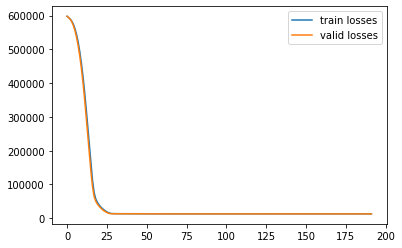

In [180]:
plt.plot(train_rec_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
# stop_ctr = train_ctr_hist.index(0)
# plt.axvline(stop_ctr,linestyle='--',color=emp_color,label='stop \ncontrastive \nlearning')

plt.legend()

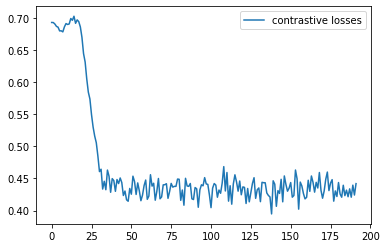

In [181]:
plt.plot(train_ctr_hist,label="contrastive losses")
plt.legend()

In [182]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))
for i, (x, y, e) in enumerate(pair1):
    break
enc_path, dec_path

('/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/enc_1.pt',
 '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/dec_1.pt')

Text(0, 0.5, 'True Event')

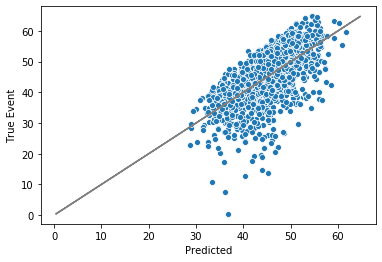

In [183]:
encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))

Text(0, 0.5, 'True Event')

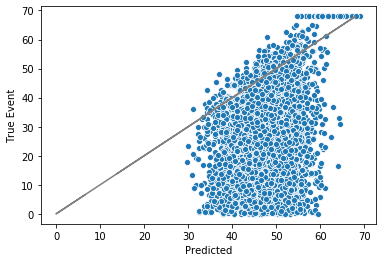

In [186]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==0], y[e==0], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')


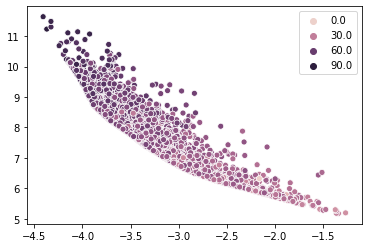

In [185]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [820]:
# torch.where(e==1),
np.where(test['t']>t_max)

(array([  17,   19,  105,  198,  348,  472,  743,  749,  940, 1009, 1085,
        1180, 1209, 1438, 1504, 1565, 1825, 1951, 2096, 2120, 2251, 2499,
        2555, 2775, 3088, 3090, 3246, 3305, 3338, 3923, 4054, 4202, 4252,
        4298, 4317, 4318, 4357, 4373, 4511, 4626, 4678, 4772, 4970]),)

(tensor(68.), tensor(0))

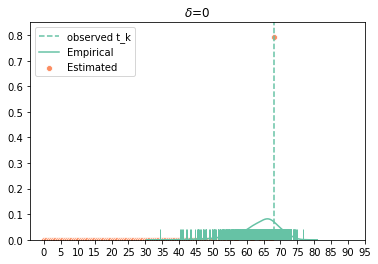

In [825]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
y_cat = batch_t_categorize(y, e, tt)


subj = 4511


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]

# y_cat = batch_t_categorize(y, e, tt)

# subj = 331
# x = x.to(device).float()
# z = encoder(x)
# p_raw = decoder(z)
# plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
# true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
# sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
# plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

# plt.legend(loc='upper right')
# plt.title(r'$\delta$='+str(e[subj].item()))
# y[subj], e[subj]

In [431]:
e.float().mean()

tensor(0.2660)

In [46]:
np.arange(0, 70, step=5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [240]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    clf.train()
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):

        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)
        train_loss += loss.item()
        opt_clf.step()    

    train_loss = train_loss/(i+1)
    
    clf.eval()
    valid_loss = 0
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        valid_loss_ = BCEloss(pred_label.squeeze(), batch_label.float())

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss_):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss_
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid Pair number: {} \tCE loss: {:.4f} \tImproved: {}'.format(len(e1), valid_loss_.item(), improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

epoch1
====> Valid Pair number: 649 	CE loss: 0.8527 	Improved: *
epoch2
====> Valid Pair number: 641 	CE loss: 0.7976 	Improved: *
epoch3
====> Valid Pair number: 653 	CE loss: 0.7649 	Improved: *
epoch4
====> Valid Pair number: 657 	CE loss: 0.6971 	Improved: *
epoch5
====> Valid Pair number: 630 	CE loss: 0.6617 	Improved: *
epoch6
====> Valid Pair number: 632 	CE loss: 0.6347 	Improved: *
epoch7
====> Valid Pair number: 648 	CE loss: 0.6240 	Improved: *
epoch8
====> Valid Pair number: 643 	CE loss: 0.6128 	Improved: *
epoch9
====> Valid Pair number: 658 	CE loss: 0.6176 	Improved:  
epoch10
====> Valid Pair number: 638 	CE loss: 0.5913 	Improved: *
epoch11
====> Valid Pair number: 656 	CE loss: 0.5862 	Improved: *
epoch12
====> Valid Pair number: 621 	CE loss: 0.5889 	Improved:  
epoch13
====> Valid Pair number: 667 	CE loss: 0.5741 	Improved: *
epoch14
====> Valid Pair number: 605 	CE loss: 0.5729 	Improved: *
epoch15
====> Valid Pair number: 643 	CE loss: 0.5616 	Improved: *
epoc

====> Valid Pair number: 664 	CE loss: 0.4939 	Improved:  
epoch124
====> Valid Pair number: 674 	CE loss: 0.4727 	Improved:  
epoch125
====> Valid Pair number: 637 	CE loss: 0.5000 	Improved:  
epoch126
====> Valid Pair number: 648 	CE loss: 0.5156 	Improved:  
epoch127
====> Valid Pair number: 648 	CE loss: 0.4763 	Improved:  
epoch128
====> Valid Pair number: 664 	CE loss: 0.4897 	Improved:  
epoch129
====> Valid Pair number: 626 	CE loss: 0.4832 	Improved:  
epoch130
====> Valid Pair number: 617 	CE loss: 0.4953 	Improved:  
epoch131
====> Valid Pair number: 668 	CE loss: 0.4815 	Improved:  
epoch132
====> Valid Pair number: 661 	CE loss: 0.4700 	Improved:  
epoch133
====> Valid Pair number: 653 	CE loss: 0.5065 	Improved:  
epoch134
====> Valid Pair number: 682 	CE loss: 0.4861 	Improved:  
epoch135
====> Valid Pair number: 640 	CE loss: 0.4857 	Improved:  
epoch136
====> Valid Pair number: 647 	CE loss: 0.4832 	Improved:  
epoch137
====> Valid Pair number: 618 	CE loss: 0.5129 	I

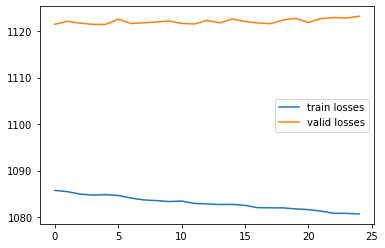

In [396]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [242]:
import pandas as pd


plot_df = pd.DataFrame({'true': batch_label.detach().numpy(), 'pred': pred_label.squeeze().detach().numpy(),\
                        'dataPair1':batch_pair[:,0].detach().numpy(), 'dataPair2':batch_pair[:,1].detach().numpy()})
plot_df.head()

,true,pred,dataPair1,dataPair2
0,1.0,0.744528,25.781141,43.624172
1,1.0,0.744528,15.027925,21.310776
2,1.0,0.744528,20.414146,30.561441
3,1.0,0.744528,22.647816,30.683744
4,0.0,0.742164,15.022316,19.621126


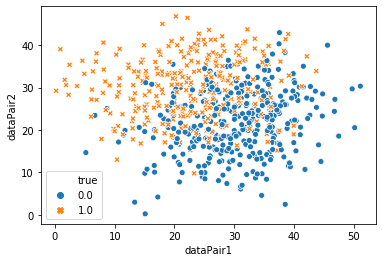

In [243]:
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")


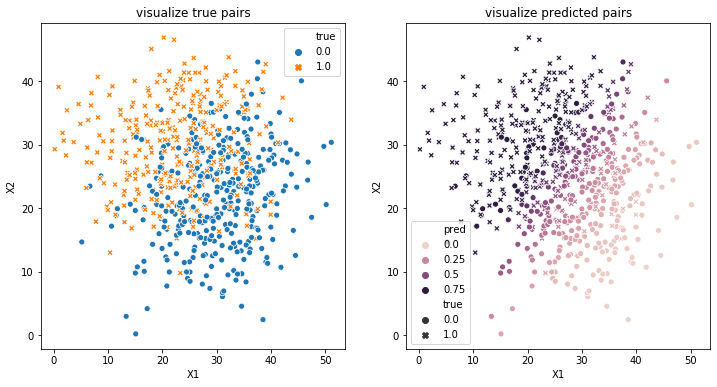

In [244]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)

_ = plt.title('visualize true pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')
plt.subplot(1, 2, 2)



_ = plt.title('visualize predicted pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="pred", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

In [257]:
subj = np.random.sample(np.where(test['e']==1))
subj

TypeError: only integer scalar arrays can be converted to a scalar index

In [258]:
np.where(test['e']==1)

(array([  14,   16,   19, ..., 4992, 4996, 4998]),)

In [288]:
np.where(test['e']==1)
subj = 14

In [422]:
# Restore variables from disk.
clf.load_state_dict(torch.load(clf_path))
print("Model restored.")

# new object to predict g(x_subj)
# on the left
# subj = 2
# on the right
# subj=6
# relatively good 
# subj=8
x_subj = test['x'][subj]     # You can play with this
# x_subj = train['x'][subj]
draw_dataset = test
# Return evenly spaced numbers over a specified interval.
# is tt the we want?
# change tt to percentage scale

tt = np.percentile(train['T'],np.delete(np.linspace(0.,100.,1000, endpoint=False),0))
tt_bin = np.ones(len(tt))
# tt = np.linspace(ST[0]-0.5,ST[-1]+0.5,1000).reshape(1000)
# tt_bin = [y-x for x, y in zip(tt[:-1], tt[1:])]
# tt = np.delete(tt,0)

# SFX sorted original training dataset
x_subj_query = np.concatenate((np.tile(x_subj,[SX.shape[0],1]),SX),axis=1)

prob_subj = clf(torch.tensor(x_subj_query).to(device).float()).squeeze().detach().numpy()

# ST: sorted g(X_train)
# returns a matrix of size(tt)*size(ST)
# each ST corresponding to SFX
TC = compute_concord(tt,ST)

EPS = 1e-10
#aggregate information over bins
# binomial log-likelihood
tau = 0.2
score = np.mean(np.log(prob_subj+EPS)*TC+np.log(1-prob_subj+EPS)*(1-TC),axis=1)
score = score/tau
# normalize based on bin size!
post_prob = (np.exp(score)*tt_bin)/np.sum(np.exp(score)*tt_bin)

# np.save(output_dir+'/'+'M'+str(M0)+'replicate'+str(replicate_number)+"_MLP_post_prob",post_prob)




RuntimeError: Error(s) in loading state_dict for SimpleMLP:
	size mismatch for net.0.weight: copying a param with shape torch.Size([32, 2]) from checkpoint, the shape in current model is torch.Size([32, 4]).

In [2]:
width = 18
height = 6
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)

plt.plot(SX, prob_subj, 'o')
plt.xlabel("sorted training X")
plt.ylabel("classifier output")
plt.axvline(draw_dataset['x'][subj],linestyle='--', label='x_k')
plt.legend()

plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")


# plt.subplot(1,3,2)
# plt.plot(ST, prob_subj, 'o')
# plt.xlabel("training T based on sorted X")
# plt.ylabel("classifier output")
# plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
# plt.legend()
# plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")
# # plt.xlim(50,80)

plt.subplot(1,2,2)
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']

plt.plot(tt, post_prob/0.1, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False,label="Empirical")
plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')


#
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')


plt.legend()
plt.title("Time-to-event distribution, event label:{}".format(test['e'][subj]))

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Time-to-event distribution')

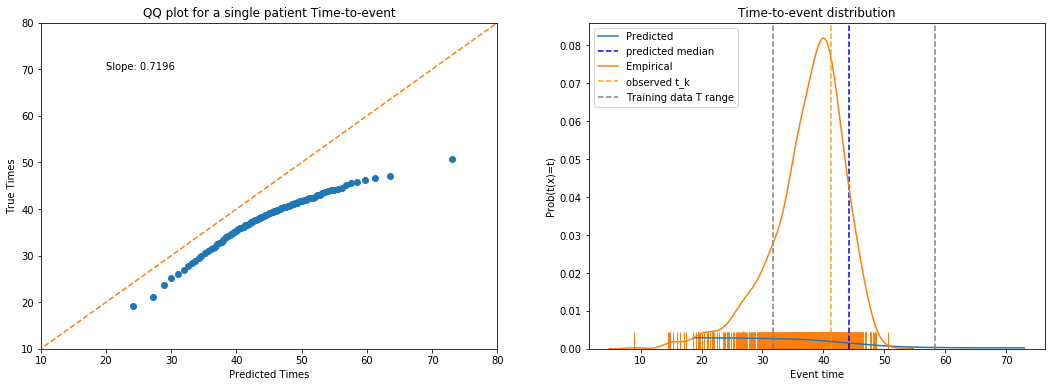

In [282]:
# calculate QQ-plot
import numpy as np
import matplotlib.pyplot as plt


pred_quantiles = calculate_quantiles(post_prob, tt, percentiles=np.linspace(0,1,100))
true_quantiles = np.percentile(true_T,np.linspace(0,100,100))
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pred_quantiles, true_quantiles)

width = 18
height = 6
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.text(20,70, 'Slope: '+str(np.round(slope,4)))
plt.plot(pred_quantiles, true_quantiles, 'o')
plt.plot(np.linspace(0,100,100),np.linspace(0,100,100), linestyle='--')
plt.xlim(10,80)
plt.ylim(10,80)
plt.xlabel('Predicted Times')
plt.ylabel('True Times')
plt.title('QQ plot for a single patient Time-to-event')

plt.subplot(1,2,2)
plt.plot(tt, post_prob, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False, label="Empirical")

plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')

plt.legend()
plt.title("Time-to-event distribution")

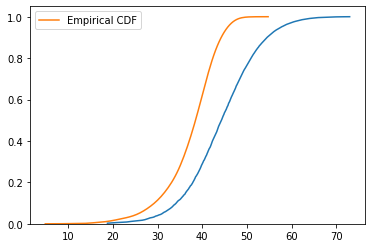

In [283]:
plt.plot(tt,np.cumsum(post_prob))
sns.distplot(true_T, hist=False, label="Empirical CDF", kde_kws=dict(cumulative=True))
